## Import Libraries and Data

In [77]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_March2023.csv', firstRow=108, lastRow=114)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_270223_S109-114.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)

## Analyse water addition

In [78]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=112s and ended at t=506s; mass=45.05585g
This equals a volume of 45.146m; expected was 45.355mL; error is 0.46%


## Analyise surfactants

Peak threshold for 1st derivative = 0.0035 g/s and for 2nd derivative = 0.0010624999999999999 g/s^2


<IPython.core.display.Javascript object>


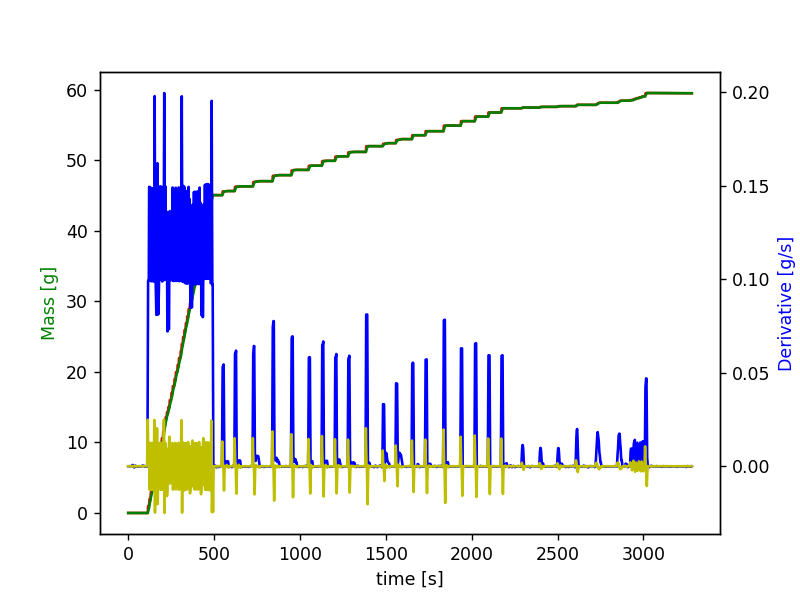

Addition of 0.557g Plantapon ACG 50 detected from 544s to 564s - expected volume = 0.563mL and actual volume = 0.498mL (resulting error is 11.657%)
Addition of 0.633g Plantapon ACG 50 detected from 616s to 636s - expected volume = 0.563mL and actual volume = 0.565mL (resulting error is 0.349%)
Addition of 0.75g Plantapon LC 7 detected from 722s to 764s - expected volume = 0.918mL and actual volume = 0.701mL (resulting error is 23.672%)
Addition of 0.835g Plantacare 818 detected from 836s to 868s - expected volume = 0.991mL and actual volume = 0.77mL (resulting error is 22.335%)
Addition of 0.746g Plantacare 2000 detected from 946s to 978s - expected volume = 0.837mL and actual volume = 0.689mL (resulting error is 17.74%)
Addition of 0.586g Dehyton MC detected from 1046s to 1066s - expected volume = 0.6mL and actual volume = 0.544mL (resulting error is 9.366%)
Addition of 0.667g Dehyton MC detected from 1124s to 1144s - expected volume = 0.6mL and actual volume = 0.619mL (resulting erro

In [79]:
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant',steps=steps,start_idx=t1,show=True)

## Analyse polyelectrolytes

Peak threshold for 1st derivative = 0.0046875 g/s and for 2nd derivative = 0.0017187499999999998 g/s^2


<IPython.core.display.Javascript object>


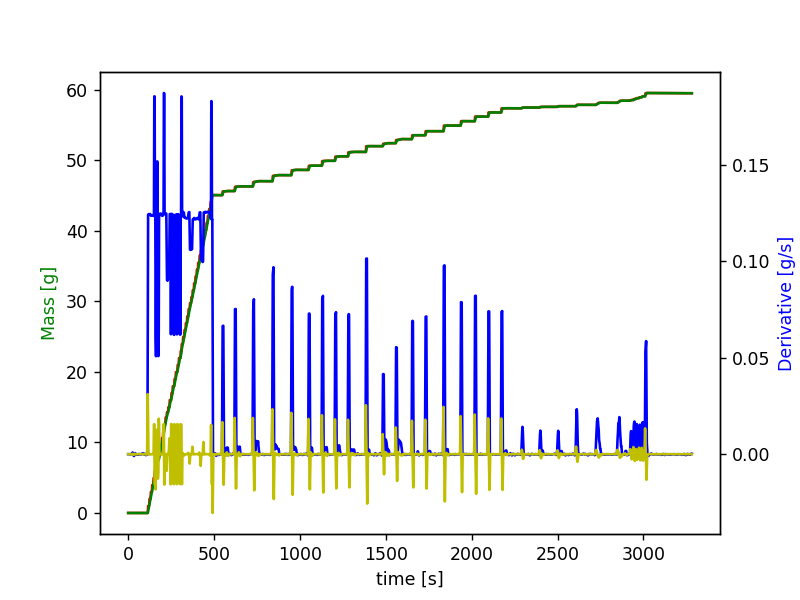

Addition of 0.11g Luviquat Excellence detected from 2288s to 2306s - expected volume = 0.126mL and actual volume = 0.101mL (resulting error is 19.891%)
Addition of 0.097g Luviquat Excellence detected from 2394s to 2408s - expected volume = 0.098mL and actual volume = 0.087mL (resulting error is 11.477%)
Addition of 0.096g Luviquat Excellence detected from 2498s to 2512s - expected volume = 0.092mL and actual volume = 0.088mL (resulting error is 4.827%)
Addition of 0.197g Luviquat Excellence detected from 2604s to 2622s - expected volume = 0.183mL and actual volume = 0.176mL (resulting error is 4.146%)
Addition of 0.306g Luviquat Excellence detected from 2722s to 2750s - expected volume = 0.271mL and actual volume = 0.278mL (resulting error is 2.559%)
Addition of 0.29g Luviquat Excellence detected from 2846s to 2872s - expected volume = 0.262mL and actual volume = 0.263mL (resulting error is 0.389%)


In [81]:
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=4, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)
# usually bl_mult = 6, but parameter dependent on noise in baseline.

## Analyse Thickeners

Peak threshold for 1st derivative = 0.018000000000000002 g/s and for 2nd derivative = 0.0073125 g/s^2


<IPython.core.display.Javascript object>


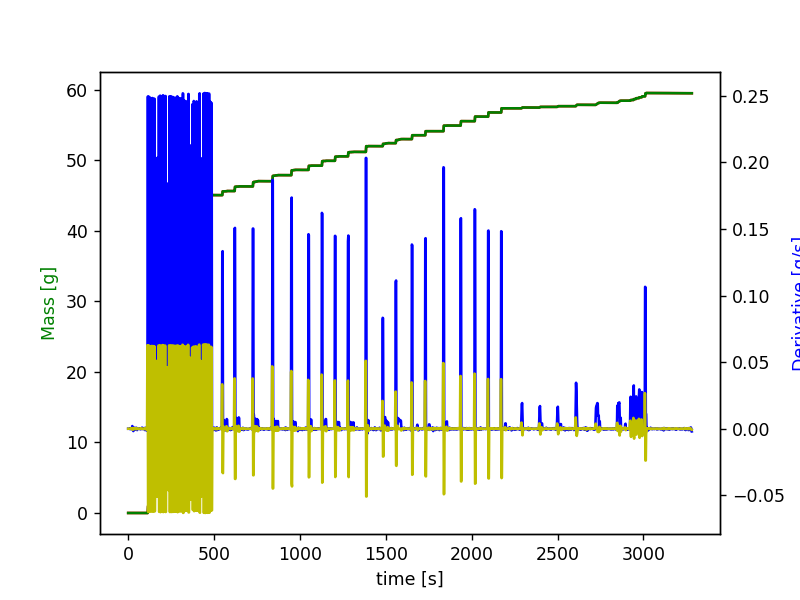

Addition of 0.21g Arlypon TT detected from 2922s to 2944s - expected volume = 0.107mL and actual volume = 0.221mL (resulting error is 107.426%)
Addition of 0.236g Arlypon TT detected from 2944s to 2958s - expected volume = 0.132mL and actual volume = 0.243mL (resulting error is 84.375%)
Addition of 0.105g Arlypon TT detected from 2972s to 2976s - expected volume = 0.111mL and actual volume = 0.11mL (resulting error is 1.415%)
Addition of 0.344g Arlypon TT detected from 2988s to 3010s - expected volume = 0.114mL and actual volume = 0.354mL (resulting error is 209.91%)
Addition of 0.448g Arlypon TT detected from 3010s to 3014s - expected volume = 0.13mL and actual volume = 0.47mL (resulting error is 261.29%)


StopIteration: 

In [82]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=9, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [76]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_270223_S109-S114.csv', index=False)
actualMassFractions

AttributeError: 'PipettingStep' object has no attribute 'addedMass'